In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
from keras.models import model_from_json
from mask_utils import get_images, get_input_prediction_tiles, image_from_tiles

Using TensorFlow backend.
/home/rallen/anaconda3/envs/dl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Load the model & weights that were most-recently created by train_mask_model.py.

In [2]:
model_file   = 'data/results/model_171223.json'
weights_file = 'data/results/mask_weights_171223_134224.h5'

# very interesting comparison.  Nomaxpool is WAY better than maxpool-enabled.
#model_file   = 'data/results/model_171112.json'
#weights_file = 'data/results/mask_weights_171112_123000.h5'

with open(model_file,"r") as f:
    json_string = f.read()
model = model_from_json(json_string)
model.load_weights(weights_file)

Now loop through the test cases, predicting the images and storing them as mask png files.

In [3]:
for base_name in ['chromatic','chromatic_piano','gen_one','gen_two','twinkle']:
    print(f"predicting {base_name}")
    score_image, mask_image = get_images(base_name)
    input_tiles = get_input_prediction_tiles(score_image)
    pred_tiles = model.predict(input_tiles)
    pred_one = image_from_tiles(score_image.width, score_image.height, 
                                input_tiles.shape[0], pred_tiles, 1)
    #pred_one
    with open(f"data/results/pred_mask_{base_name}.png",'wb') as f:
        pred_one.save(f)

predicting chromatic
predicting chromatic_piano
predicting gen_one
predicting gen_two
predicting twinkle


Compare the predicted vs. expected images... You'll probably want to do this outside of Jupyter notebook...

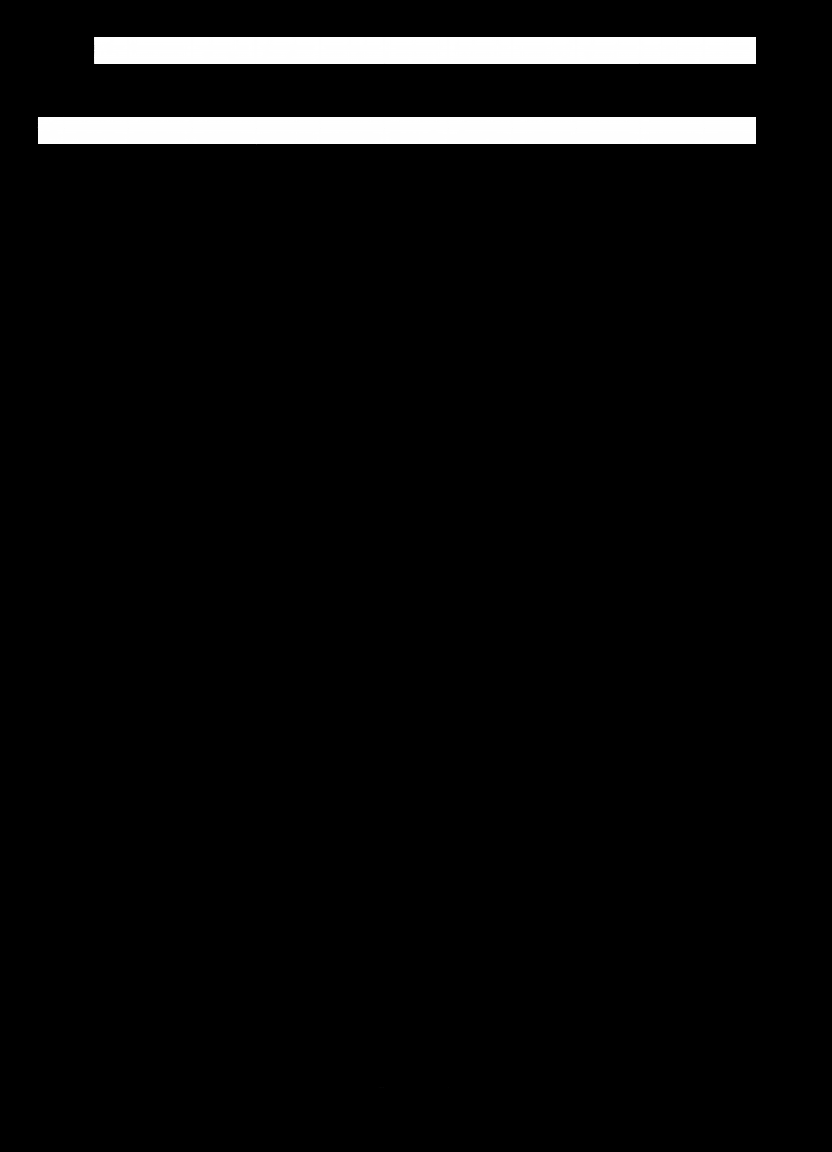

In [4]:
pred_one

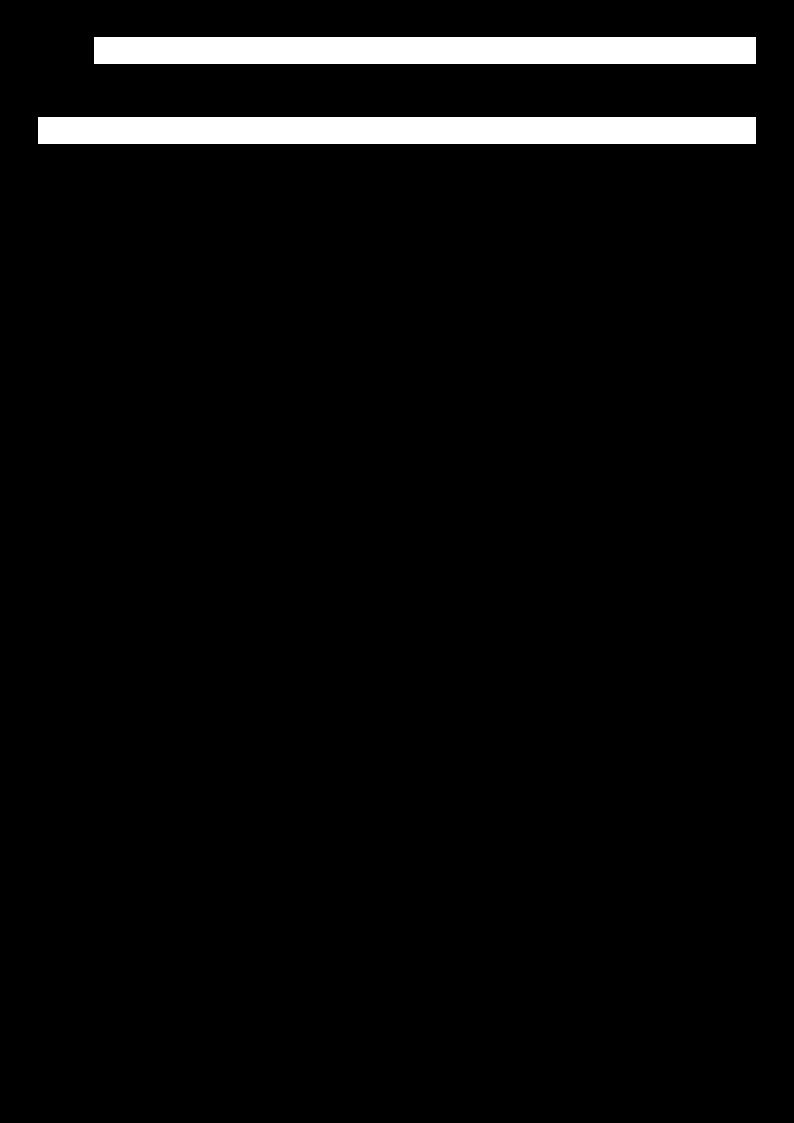

In [5]:
mask_image